In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = convolution_block(
        residual_block_pool, residual_convolution_options)
    residual_block = convolution_block(
        residual_block, residual_convolution_options)

    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = residual_block(averaged_embedding_layer, should_pool = False)
model = residual_block(model, should_pool = True)
model = residual_block(model, should_pool = True)
model = residual_block(model, should_pool = True)
model = residual_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21088/102124 [=====>........................] - ETA: 4:56 - loss: 0.1234 - acc: 0.9582

 59872/102124 [================>.............] - ETA: 2:22 - loss: 0.0876 - acc: 0.9700

 99296/102124 [============================>.] - ETA: 9s - loss: 0.0764 - acc: 0.9735

102124/102124 [==============================] - 361s 4ms/step - loss: 0.0759 - acc: 0.9736 - val_loss: 0.0484 - val_acc: 0.9821
Epoch 2/32
 12832/102124 [==>...........................] - ETA: 4:48 - loss: 0.0599 - acc: 0.9775

 54176/102124 [==============>...............] - ETA: 2:35 - loss: 0.0568 - acc: 0.9791

 95744/102124 [===========================>..] - ETA: 20s - loss: 0.0555 - acc: 0.9796

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0557 - acc: 0.9796 - val_loss: 0.0523 - val_acc: 0.9797
roc-auc: 0.98 - roc-auc_val: 0.9755                                                                                                    
Epoch 3/32
  7104/102124 [=>............................] - ETA: 5:05 - loss: 0.0530 - acc: 0.9807

 67232/102124 [==================>...........] - ETA: 1:53 - loss: 0.0527 - acc: 0.9805

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0524 - acc: 0.9806 - val_loss: 0.0474 - val_acc: 0.9824
Epoch 4/32
   608/102124 [..............................] - ETA: 5:36 - loss: 0.0398 - acc: 0.9846

 59200/102124 [================>.............] - ETA: 2:19 - loss: 0.0504 - acc: 0.9811

102112/102124 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9816

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0494 - acc: 0.9816 - val_loss: 0.0429 - val_acc: 0.9834
roc-auc: 0.9846 - roc-auc_val: 0.9806                                                                                                    
Epoch 5/32
  8640/102124 [=>............................] - ETA: 5:02 - loss: 0.0497 - acc: 0.9813

 45376/102124 [============>.................] - ETA: 3:03 - loss: 0.0493 - acc: 0.9815

 99936/102124 [============================>.] - ETA: 7s - loss: 0.0480 - acc: 0.9819

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0481 - acc: 0.9819 - val_loss: 0.0432 - val_acc: 0.9835
Epoch 6/32
 13056/102124 [==>...........................] - ETA: 4:48 - loss: 0.0462 - acc: 0.9818

 70592/102124 [===================>..........] - ETA: 1:42 - loss: 0.0465 - acc: 0.9821

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0464 - acc: 0.9823 - val_loss: 0.0486 - val_acc: 0.9802

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.987 - roc-auc_val: 0.9834                                                                                                    
Epoch 7/32
   992/102124 [..............................] - ETA: 5:27 - loss: 0.0551 - acc: 0.9790

 37760/102124 [==========>...................] - ETA: 3:30 - loss: 0.0453 - acc: 0.9828

 80416/102124 [======================>.......] - ETA: 1:10 - loss: 0.0459 - acc: 0.9826

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0460 - acc: 0.9826 - val_loss: 0.0438 - val_acc: 0.9830
Epoch 8/32
  5760/102124 [>.............................] - ETA: 5:13 - loss: 0.0421 - acc: 0.9841

 46016/102124 [============>.................] - ETA: 3:02 - loss: 0.0436 - acc: 0.9832

 96128/102124 [===========================>..] - ETA: 19s - loss: 0.0446 - acc: 0.9828

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0447 - acc: 0.9828 - val_loss: 0.0424 - val_acc: 0.9835
roc-auc: 0.9885 - roc-auc_val: 0.9837                                                                                                    
Epoch 9/32
  7296/102124 [=>............................] - ETA: 5:08 - loss: 0.0437 - acc: 0.9832

 44192/102124 [===========>..................] - ETA: 3:07 - loss: 0.0441 - acc: 0.9830

 85440/102124 [========================>.....] - ETA: 54s - loss: 0.0440 - acc: 0.9830

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0417 - val_acc: 0.9835
Epoch 10/32
  7648/102124 [=>............................] - ETA: 5:07 - loss: 0.0426 - acc: 0.9837

 53760/102124 [==============>...............] - ETA: 2:37 - loss: 0.0435 - acc: 0.9832

 90720/102124 [=========================>....] - ETA: 37s - loss: 0.0430 - acc: 0.9834

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0430 - acc: 0.9834 - val_loss: 0.0445 - val_acc: 0.9827
roc-auc: 0.9899 - roc-auc_val: 0.9851                                                                                                    
Epoch 11/32
  6016/102124 [>.............................] - ETA: 5:14 - loss: 0.0419 - acc: 0.9835

 46432/102124 [============>.................] - ETA: 3:01 - loss: 0.0427 - acc: 0.9834

 92928/102124 [==========================>...] - ETA: 29s - loss: 0.0426 - acc: 0.9833

102124/102124 [==============================] - 354s 3ms/step - loss: 0.0425 - acc: 0.9834 - val_loss: 0.0419 - val_acc: 0.9834
Epoch 12/32
 10464/102124 [==>...........................] - ETA: 4:57 - loss: 0.0409 - acc: 0.9845

 75072/102124 [=====================>........] - ETA: 1:27 - loss: 0.0417 - acc: 0.9838

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0419 - acc: 0.9838 - val_loss: 0.0424 - val_acc: 0.9832
roc-auc: 0.9911 - roc-auc_val: 0.9863                                                                                                    
Epoch 13/32
  2176/102124 [..............................] - ETA: 5:17 - loss: 0.0449 - acc: 0.9822

 49440/102124 [=============>................] - ETA: 2:49 - loss: 0.0404 - acc: 0.9842

 86016/102124 [========================>.....] - ETA: 52s - loss: 0.0411 - acc: 0.9840

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0414 - acc: 0.9838 - val_loss: 0.0428 - val_acc: 0.9830
Epoch 14/32
  7776/102124 [=>............................] - ETA: 5:06 - loss: 0.0426 - acc: 0.9837

 44928/102124 [============>.................] - ETA: 3:04 - loss: 0.0411 - acc: 0.9838

 80992/102124 [======================>.......] - ETA: 1:08 - loss: 0.0407 - acc: 0.9840

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0408 - acc: 0.9840 - val_loss: 0.0418 - val_acc: 0.9837
roc-auc: 0.9915 - roc-auc_val: 0.987                                                                                                    
Epoch 15/32
  3360/102124 [..............................] - ETA: 5:15 - loss: 0.0442 - acc: 0.9825

 42080/102124 [===========>..................] - ETA: 3:14 - loss: 0.0411 - acc: 0.9838

 77920/102124 [=====================>........] - ETA: 1:18 - loss: 0.0401 - acc: 0.9843

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0410 - val_acc: 0.9837
Epoch 16/32
  4384/102124 [>.............................] - ETA: 5:16 - loss: 0.0401 - acc: 0.9845

 43040/102124 [===========>..................] - ETA: 3:09 - loss: 0.0405 - acc: 0.9841

 78272/102124 [=====================>........] - ETA: 1:16 - loss: 0.0401 - acc: 0.9843

102124/102124 [==============================] - 348s 3ms/step - loss: 0.0399 - acc: 0.9843 - val_loss: 0.0418 - val_acc: 0.9834
roc-auc: 0.9924 - roc-auc_val: 0.9876                                                                                                    
Epoch 17/32
  2592/102124 [..............................] - ETA: 5:17 - loss: 0.0365 - acc: 0.9862

 50720/102124 [=============>................] - ETA: 2:45 - loss: 0.0390 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9846

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0392 - acc: 0.9846 - val_loss: 0.0408 - val_acc: 0.9838
Epoch 18/32
 13952/102124 [===>..........................] - ETA: 4:45 - loss: 0.0396 - acc: 0.9847

 61408/102124 [=================>............] - ETA: 2:12 - loss: 0.0387 - acc: 0.9847

 97888/102124 [===========================>..] - ETA: 13s - loss: 0.0387 - acc: 0.9847

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0387 - acc: 0.9847 - val_loss: 0.0412 - val_acc: 0.9837
roc-auc: 0.9929 - roc-auc_val: 0.9882                                                                                                    
Epoch 19/32
  7136/102124 [=>............................] - ETA: 5:03 - loss: 0.0397 - acc: 0.9841

 45664/102124 [============>.................] - ETA: 3:02 - loss: 0.0388 - acc: 0.9845

 89440/102124 [=========================>....] - ETA: 41s - loss: 0.0388 - acc: 0.9846

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0388 - acc: 0.9846 - val_loss: 0.0409 - val_acc: 0.9837

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/32
  6752/102124 [>.............................] - ETA: 5:10 - loss: 0.0393 - acc: 0.9846

 54016/102124 [==============>...............] - ETA: 2:36 - loss: 0.0380 - acc: 0.9849

 89568/102124 [=========================>....] - ETA: 40s - loss: 0.0382 - acc: 0.9848

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0382 - acc: 0.9847 - val_loss: 0.0405 - val_acc: 0.9840
roc-auc: 0.9934 - roc-auc_val: 0.9884                                                                                                    
Epoch 21/32
  5216/102124 [>.............................] - ETA: 5:08 - loss: 0.0389 - acc: 0.9846

 41472/102124 [===========>..................] - ETA: 3:14 - loss: 0.0377 - acc: 0.9850

 76128/102124 [=====================>........] - ETA: 1:23 - loss: 0.0379 - acc: 0.9849

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0379 - acc: 0.9850 - val_loss: 0.0404 - val_acc: 0.9840
Epoch 22/32
  3680/102124 [>.............................] - ETA: 5:21 - loss: 0.0370 - acc: 0.9845

 39648/102124 [==========>...................] - ETA: 3:21 - loss: 0.0373 - acc: 0.9853

 82688/102124 [=======================>......] - ETA: 1:02 - loss: 0.0375 - acc: 0.9851

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0415 - val_acc: 0.9836
roc-auc: 0.9937 - roc-auc_val: 0.9882                                                                                                    
Epoch 23/32
  3968/102124 [>.............................] - ETA: 5:19 - loss: 0.0388 - acc: 0.9841

 45248/102124 [============>.................] - ETA: 3:04 - loss: 0.0370 - acc: 0.9852

 85152/102124 [========================>.....] - ETA: 54s - loss: 0.0374 - acc: 0.9851

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0375 - acc: 0.9851 - val_loss: 0.0412 - val_acc: 0.9836
Epoch 24/32
  6912/102124 [=>............................] - ETA: 5:05 - loss: 0.0374 - acc: 0.9845

 42240/102124 [===========>..................] - ETA: 3:13 - loss: 0.0378 - acc: 0.9846

 78688/102124 [======================>.......] - ETA: 1:15 - loss: 0.0374 - acc: 0.9849

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0371 - acc: 0.9850 - val_loss: 0.0423 - val_acc: 0.9833
roc-auc: 0.9939 - roc-auc_val: 0.9884                                                                                                    
Epoch 25/32
  3008/102124 [..............................] - ETA: 5:16 - loss: 0.0384 - acc: 0.9835

 38688/102124 [==========>...................] - ETA: 3:23 - loss: 0.0367 - acc: 0.9851

 81440/102124 [======================>.......] - ETA: 1:06 - loss: 0.0368 - acc: 0.9852

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0370 - acc: 0.9852 - val_loss: 0.0403 - val_acc: 0.9841
Epoch 26/32
  5792/102124 [>.............................] - ETA: 5:10 - loss: 0.0373 - acc: 0.9852

 40768/102124 [==========>...................] - ETA: 3:17 - loss: 0.0363 - acc: 0.9854

 77984/102124 [=====================>........] - ETA: 1:17 - loss: 0.0363 - acc: 0.9856

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0366 - acc: 0.9852 - val_loss: 0.0406 - val_acc: 0.9840
roc-auc: 0.994 - roc-auc_val: 0.9885                                                                                                    
Epoch 27/32
  2944/102124 [..............................] - ETA: 5:20 - loss: 0.0351 - acc: 0.9856

 38912/102124 [==========>...................] - ETA: 3:23 - loss: 0.0365 - acc: 0.9855

 75872/102124 [=====================>........] - ETA: 1:24 - loss: 0.0366 - acc: 0.9855

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0364 - acc: 0.9856 - val_loss: 0.0415 - val_acc: 0.9836
Epoch 28/32
  3776/102124 [>.............................] - ETA: 5:16 - loss: 0.0350 - acc: 0.9865

 45664/102124 [============>.................] - ETA: 3:02 - loss: 0.0359 - acc: 0.9857

 80384/102124 [======================>.......] - ETA: 1:09 - loss: 0.0362 - acc: 0.9854

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0363 - acc: 0.9855 - val_loss: 0.0410 - val_acc: 0.9838
roc-auc: 0.9942 - roc-auc_val: 0.9883                                                                                                    
Epoch 29/32
  3328/102124 [..............................] - ETA: 5:22 - loss: 0.0394 - acc: 0.9851

 55872/102124 [===============>..............] - ETA: 2:30 - loss: 0.0359 - acc: 0.9856

 92224/102124 [==========================>...] - ETA: 32s - loss: 0.0359 - acc: 0.9856

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0409 - val_acc: 0.9839
Epoch 30/32
 10144/102124 [=>............................] - ETA: 4:58 - loss: 0.0365 - acc: 0.9850

 46592/102124 [============>.................] - ETA: 2:58 - loss: 0.0357 - acc: 0.9856

 83136/102124 [=======================>......] - ETA: 1:01 - loss: 0.0357 - acc: 0.9857

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0360 - acc: 0.9856 - val_loss: 0.0412 - val_acc: 0.9836

Epoch 00030: ReduceLROnPlateau reducing learning rate to 2.4518252757843584e-05.
roc-auc: 0.9943 - roc-auc_val: 0.9885                                                                                                    
Epoch 31/32
  3104/102124 [..............................] - ETA: 5:18 - loss: 0.0369 - acc: 0.9847

 39008/102124 [==========>...................] - ETA: 3:22 - loss: 0.0360 - acc: 0.9856

 74112/102124 [====================>.........] - ETA: 1:30 - loss: 0.0352 - acc: 0.9858

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0358 - acc: 0.9856 - val_loss: 0.0406 - val_acc: 0.9839
Epoch 32/32
  3008/102124 [..............................] - ETA: 5:18 - loss: 0.0313 - acc: 0.9879

 38656/102124 [==========>...................] - ETA: 3:25 - loss: 0.0346 - acc: 0.9863

 75456/102124 [=====================>........] - ETA: 1:26 - loss: 0.0355 - acc: 0.9858

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0357 - acc: 0.9857 - val_loss: 0.0414 - val_acc: 0.9837
roc-auc: 0.9945 - roc-auc_val: 0.9883                                                                                                    


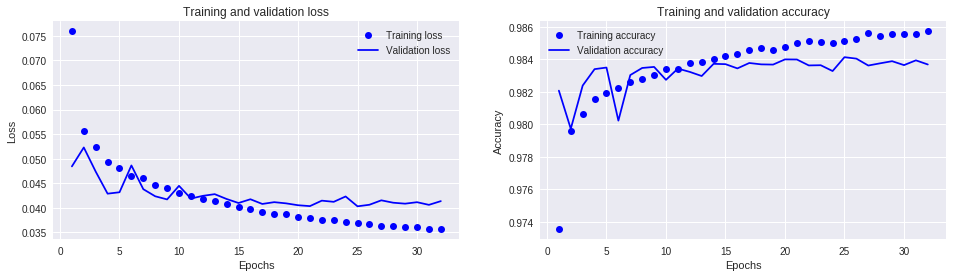

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 30s 927us/step
([0.04053532618065715, 0.983597041373527], 0.9894244281107539)
